In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns

from utils.PreProcessor import PreProcessor

In [2]:
# %time preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = True)

In [3]:
%time preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = False)

**************************************
Loading PreProcessed Datasets
Loaded AirRouteDatasets
Loaded Domestic Passenger Data
Loaded Indian Railways Data
Loaded Socio-Economic Data
Loaded Monument Visitors Data
**************************************
CPU times: user 86.3 ms, sys: 2.34 ms, total: 88.7 ms
Wall time: 86.9 ms


In [4]:
def get_cost_resource_analysis(num_planes, addition_planes):
    feasibility = True
    EARNINGS = []

    def inflation(price):
        return price * (1 + INFLATION_RATE / 100)
    def inflation_total(price, duration):
        return price * ((1 + INFLATION_RATE / 100) ** duration)

    current_price_in = PRICE_IN
    current_price_out = PRICE_OUT
    for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)):
        num_narrow, num_turbo = num_planes[year_idx]
        year_forecasts = forecasts[forecasts['Year'] == year]
        in_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic']
        out_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic']
        EARNINGS.append(
            (
                (in_demand * MARKET_SHARE_IN * current_price_in) +
                (out_demand * MARKET_SHARE_OUT * current_price_out)
            )
        )
        current_price_in = inflation(current_price_in)
        current_price_out = inflation(current_price_out)
    
    fixed_expenses_factor = 0
    operating_expenses_factor = 0
    for idx in range(FORECAST_YEAR - PRESENT_YEAR):
        operating_expenses_factor += (((duration_in + duration_out) / 60) * num_planes[idx][0] * (CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP) * 365 + ((duration_in + duration_out) / 60) * num_planes[idx][1]) * inflation_total(1, idx)
    for idx in range(len(addition_planes)):
        fixed_expenses_factor += (addition_planes[idx][0] * CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP + addition_planes[idx][1]) * inflation_total(1, FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2])
    other_expenses_factor = 1
    total_earnings = np.sum(EARNINGS)
    
    def check_cost_equation(fixed, operating, other):
        profitability = (fixed * fixed_expenses_factor + operating * operating_expenses_factor + other_expenses_factor * other - total_earnings * (1 - PROFIT_MARGIN / 100))
        return profitability, (profitability <= 0)
    
    EXPENSES = [0] * (FORECAST_YEAR - PRESENT_YEAR)
    EXPENSES[0] += OTHER_COSTS
    current_operating_expense = OPERATING_COSTS
    for idx in range(FORECAST_YEAR - PRESENT_YEAR):
        year_operating_expense = current_operating_expense * (((duration_in + duration_out) / 60) * num_planes[idx][0] * (CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP) * 365 + ((duration_in + duration_out) / 60) * num_planes[idx][1])
        EXPENSES[idx] += year_operating_expense
        current_operating_expense = inflation(current_operating_expense)
    for idx in range(len(addition_planes)):
        fixed_costs = FIXED_COSTS * (addition_planes[idx][0] * CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP + addition_planes[idx][1]) * inflation_total(1, FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2])
        EXPENSES[FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2]] += fixed_costs
    
    years = np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)
    PROFIT_MARGIN_LIST = (np.cumsum(EARNINGS) - np.cumsum(EXPENSES)) / (np.cumsum(EARNINGS)) * 100
    
    if(check_cost_equation(FIXED_COSTS, OPERATING_COSTS, OTHER_COSTS)[1] == False):
        feasibility = False
        return feasibility, {
            'years': years,
            'EXPENSES': EXPENSES,
            'EARNINGS': EARNINGS,
            'PROFIT_MARGIN_LIST': PROFIT_MARGIN_LIST,
            'total_demands': None,
            'total_capacities': None,
            'total_flight_vacancies': None,
            'profitability_year': None
        }
    
    profitability_year = years[np.where((np.cumsum(EARNINGS) - np.cumsum(EXPENSES)) > 0)[0][0]]
    
    total_demands = []
    total_capacities = []
    total_flight_vacancies = []
    for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)):
        year_forecasts = forecasts[forecasts['Year'] == year]
        total_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic'] * MARKET_SHARE_IN + year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic'] * MARKET_SHARE_OUT
        total_capacity = (num_planes[year_idx][0] * CAPACITY_NARROW_BODY + num_planes[year_idx][1] * CAPACITY_TURBOPROP) * 2 * 365
        total_demands.append(total_demand)
        total_capacities.append(total_capacity)
        total_flight_vacancies.append(1 - (total_demand / total_capacity))
    
    return feasibility, {
        'years': years,
        'EXPENSES': EXPENSES,
        'EARNINGS': EARNINGS,
        'PROFIT_MARGIN_LIST': PROFIT_MARGIN_LIST,
        'total_demands': total_demands,
        'total_capacities': total_capacities,
        'total_flight_vacancies': total_flight_vacancies,
        'profitability_year': profitability_year
    }

In [5]:
def plot_cost_resource_analysis(feasibility, years, EXPENSES, EARNINGS, PROFIT_MARGIN_LIST, total_demands, total_capacities, total_flight_vacancies, profitability_year):
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    sns.lineplot(x = years, y = EARNINGS, label = "Earnings", ax = ax, color = 'green', linewidth = 3)
    sns.lineplot(x = years, y = EXPENSES, label = "Expenses", ax = ax, color = 'red', linewidth = 3)
    ax.fill_between(years, EARNINGS, EXPENSES, color = '#ffff0022')
    ax.legend(loc = 'best', fontsize = 10)
    ax.set_title(f"Yearly Earnings vs. Expenses", fontsize = 15)
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    sns.lineplot(x = years, y = np.cumsum(EARNINGS), label = "Earnings", ax = ax, color = 'green', linewidth = 3)
    sns.lineplot(x = years, y = np.cumsum(EXPENSES), label = "Expenses", ax = ax, color = 'red', linewidth = 3)
    ax.fill_between(years, np.cumsum(EARNINGS), np.cumsum(EXPENSES), color = '#ffff0022')
    ax.legend(loc = 'best', fontsize = 10)
    ax.set_title(f"Cumulative Earnings vs. Expenses", fontsize = 15)
    plt.show()
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    sns.lineplot(x = years, y =PROFIT_MARGIN_LIST, linewidth = 3)
    ax.hlines(0, xmin = years[0], xmax = years[-1], color = 'black')
    if(feasibility == True):
        ax.set_title(f"Profitability forecasted around {profitability_year}", fontsize = 15)
    else:
        ax.hlines(PROFIT_MARGIN, xmin = years[0], xmax = years[-1], color = 'red')
        ax.set_title(f"Profitability cannot reach required Profit Margin", fontsize = 15)
    plt.show()
    
    if(feasibility == True):
        fig, ax = plt.subplots(1, 1, figsize = (15, 5))
        sns.lineplot(x = years, y = total_demands, label = 'Yearly Total Demand', ax = ax)
        sns.lineplot(x = years, y = total_capacities, label = 'Yearly Total Capacity', ax = ax)
        ax.legend(loc = 'best')
        ax.set_title(f"Average Flight Vacancies: {np.mean(total_flight_vacancies) * 100:.2f}%")
        plt.show()

# Cost/Resource Analysis

In [20]:
# Params
FORECAST_YEAR = 2033
PRESENT_YEAR = 2023
PRICE_OUT = 80
PRICE_IN = 70
CAPACITY_NARROW_BODY = 300
CAPACITY_TURBOPROP = 100
FLEET_NARROWBODY = 3
FLEET_TURBOPROP = 2
PROFIT_MARGIN = 50
INFLATION_RATE = 7
FIXED_COSTS = 10000000
OPERATING_COSTS = 1000
OTHER_COSTS = 1000000

analysis_points = [*np.arange(0, FORECAST_YEAR - PRESENT_YEAR + 1, 4) + 4] + [FORECAST_YEAR - PRESENT_YEAR]
#analysis_points = [1, 3, 5, 7, 9] + [FORECAST_YEAR - PRESENT_YEAR]

In [24]:
route_df = pd.read_csv('./Analysis_Outputs/most_growth_routes.csv')

all_route_combo_info = {}
city_to_airport_mapping = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['AirRouteData_AirportCode'].values))
for idx, row in route_df.iterrows():
    
    SELECTED_CITY = row['City']
    SELECTED_HUB_AIRPORT = row['Hub']
    print(SELECTED_CITY, SELECTED_HUB_AIRPORT)
    
    duration_in = row['IncomingFlightDuration']
    duration_out = row['OutgoingFlightDuration']
    selected_city_airport = city_to_airport_mapping[SELECTED_CITY]
    forecast_file = f"./Analysis_Outputs/Forecasted_Route_Demand/City{SELECTED_CITY}_Hub{SELECTED_HUB_AIRPORT}.csv"
    forecasts = pd.read_csv(forecast_file)
    
    route_network_data_out = preprocessor.all_network_data[(preprocessor.all_network_data['From'] == selected_city_airport) & (preprocessor.all_network_data['To'] == SELECTED_HUB_AIRPORT)]
    route_network_data_in = preprocessor.all_network_data[(preprocessor.all_network_data['To'] == selected_city_airport) & (preprocessor.all_network_data['From'] == SELECTED_HUB_AIRPORT)]

    if(route_network_data_out.shape[0] == 0):
        #print("Market Price is not known!")
        pass
    else:
        PRICE_OUT_MARKET = route_network_data_out['Cheapest Price'].mean()
        NUM_OUT_MARKET = int(route_network_data_out['Number of Flights'].sum())
        #print(f"No. of existing outgoing Flights: {NUM_OUT_MARKET}\nMarket Price: ${PRICE_OUT_MARKET:.1f}")
    #print()
    if(route_network_data_in.shape[0] == 0):
        #print("Market Price is not known!")
        pass
    else:
        PRICE_IN_MARKET = route_network_data_in['Cheapest Price'].mean()
        NUM_IN_MARKET = int(route_network_data_in['Number of Flights'].sum())
        #print(f"No. of existing incoming Flights: {NUM_IN_MARKET}\nMarket Price: ${PRICE_IN_MARKET:.1f}")

    DEMAND_IN_MAX = forecasts[forecasts['Year'] == PRESENT_YEAR].iloc[0]['AdjustedForecastedDemand_InTraffic']
    DEMAND_OUT_MAX = forecasts[forecasts['Year'] == PRESENT_YEAR].iloc[0]['AdjustedForecastedDemand_OutTraffic']

    a_in = 365 * CAPACITY_NARROW_BODY * PRICE_IN_MARKET
    b_in = 365 * CAPACITY_TURBOPROP * PRICE_IN_MARKET
    h_in = 365 * (CAPACITY_NARROW_BODY * PRICE_IN_MARKET + CAPACITY_TURBOPROP * PRICE_IN_MARKET) / 2
    g_in = ((365 * CAPACITY_NARROW_BODY * NUM_IN_MARKET * PRICE_IN) - (DEMAND_IN_MAX * PRICE_IN_MARKET)) / 2
    f_in = ((365 * CAPACITY_TURBOPROP * NUM_IN_MARKET * PRICE_IN) - (DEMAND_IN_MAX * PRICE_IN_MARKET)) / 2
    c_in = 0

    a_out = 365 * CAPACITY_NARROW_BODY * PRICE_OUT_MARKET
    b_out = 365 * CAPACITY_TURBOPROP * PRICE_OUT_MARKET
    h_out = 365 * (CAPACITY_NARROW_BODY * PRICE_OUT_MARKET + CAPACITY_TURBOPROP * PRICE_OUT_MARKET) / 2
    g_out = ((365 * CAPACITY_NARROW_BODY * NUM_OUT_MARKET * PRICE_OUT) - (DEMAND_OUT_MAX * PRICE_OUT_MARKET)) / 2
    f_out = ((365 * CAPACITY_TURBOPROP * NUM_OUT_MARKET * PRICE_OUT) - (DEMAND_OUT_MAX * PRICE_OUT_MARKET)) / 2
    c_out = 0

    def find_solution(n_narrow, n_turbo, a, b, h, g, f, c):
        return ((a*(n_narrow ** 2)) + (b*(n_turbo ** 2)) + 2*h*n_narrow*n_turbo + 2*g*n_narrow + 2*f*n_turbo + c > 0)

    solutions_in = []
    for n_narrow in np.arange(0, FLEET_NARROWBODY + 1):
        for n_turbo in np.arange(0, FLEET_TURBOPROP + 1):
            if(find_solution(n_narrow, n_turbo, a_in, b_in, h_in, g_in, f_in, c_in)):
                solutions_in.append((n_narrow, n_turbo))

    solutions_out = []
    for n_narrow in np.arange(0, FLEET_NARROWBODY + 1):
        for n_turbo in np.arange(0, FLEET_TURBOPROP + 1):
            if(find_solution(n_narrow, n_turbo, a_out, b_out, h_out, g_out, f_out, c_out)):
                solutions_out.append((n_narrow, n_turbo))

    if(len(solutions_in) == 0):
        print("NOT FEASIBLE!")
        feasible = False

    if(len(solutions_out) == 0):
        print("NOT FEASIBLE!")
        feasible = False

    solutions = list(set(solutions_in).intersection(set(solutions_out)))
    sorted_combos = sorted(solutions, key = lambda x: CAPACITY_NARROW_BODY * x[0] + CAPACITY_TURBOPROP * x[1])
    NUM_NARROW, NUM_TURBOPROP = sorted_combos[0]

    assert(a_in * (NUM_NARROW ** 2) + b_in * (NUM_TURBOPROP ** 2) + 2 * h_in * NUM_NARROW * NUM_TURBOPROP + 2 * g_in * NUM_NARROW + 2 * f_in * NUM_TURBOPROP + c_in > 0)
    assert(a_out * (NUM_NARROW ** 2) + b_out * (NUM_TURBOPROP ** 2) + 2 * h_out * NUM_NARROW * NUM_TURBOPROP + 2 * g_out * NUM_NARROW + 2 * f_out * NUM_TURBOPROP + c_out > 0)

    MARKET_SHARE_IN = ((NUM_NARROW + NUM_TURBOPROP) / PRICE_IN) / (((NUM_NARROW + NUM_TURBOPROP) / PRICE_IN) + (NUM_IN_MARKET / PRICE_IN_MARKET))
    MARKET_SHARE_OUT = ((NUM_NARROW + NUM_TURBOPROP) / PRICE_OUT) / (((NUM_NARROW + NUM_TURBOPROP) / PRICE_OUT) + (NUM_OUT_MARKET / PRICE_OUT_MARKET))

#     print(f"Entry into market with {NUM_NARROW + NUM_TURBOPROP} flight(s)!")
#     print()
#     print("Estimated Market Share:")
#     print(f"Incoming Flights: {MARKET_SHARE_IN * 100:.1f}%\nOutgoing Flights: {MARKET_SHARE_OUT * 100:.1f}%")

    DEMAND_IN_MAX_LIST = np.zeros(FORECAST_YEAR - PRESENT_YEAR + 1)
    DEMAND_OUT_MAX_LIST = np.zeros(FORECAST_YEAR - PRESENT_YEAR + 1)
    DEMAND_IN_MAX = 0
    DEMAND_OUT_MAX = 0
    count_list = []
    year_idx_list = []
    count = 0

    for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 2)):

        if(year_idx in analysis_points):

            DEMAND_IN_MAX_LIST[year_idx] = DEMAND_IN_MAX
            DEMAND_OUT_MAX_LIST[year_idx] = DEMAND_OUT_MAX
            count_list.append(count)
            year_idx_list.append(year_idx)

            count = 0
            DEMAND_IN_MAX = 0
            DEMAND_OUT_MAX = 0

        if(year <= FORECAST_YEAR):
            year_forecasts = forecasts[forecasts['Year'] == year]
            in_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic']
            out_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic']
            if(in_demand > DEMAND_IN_MAX):
                DEMAND_IN_MAX = in_demand
            if(out_demand > DEMAND_OUT_MAX):
                DEMAND_OUT_MAX = out_demand
            count += 1

    def add_to_deepest_list(a, b):
        if(type(b) == list):
            if(type(b[0]) == list):
                return [add_to_deepest_list(a, x) for x in b]
            else:
                assert(type(b[0]) == tuple)
                return [a] + b

    def find_solution(n_narrow, n_turbo, a, b, h, g, f, c):
        return ((a*(n_narrow ** 2)) + (b*(n_turbo ** 2)) + 2*h*n_narrow*n_turbo + 2*g*n_narrow + 2*f*n_turbo + c > 0)

    def get_num_planes(year_idx, prev_num_narrowbody, prev_num_turbo):
        if(year_idx in analysis_points):

            DEMAND_IN_MAX = DEMAND_IN_MAX_LIST[year_idx]
            DEMAND_OUT_MAX = DEMAND_OUT_MAX_LIST[year_idx]

            a_in = 0
            b_in = 0
            h_in = 0
            g_in = 365 * (CAPACITY_NARROW_BODY) / 2
            f_in = 365 * (CAPACITY_TURBOPROP) / 2
            c_in = -MARKET_SHARE_IN * DEMAND_IN_MAX

            a_out = 0
            b_out = 0
            h_out = 0
            g_out = 365 * (CAPACITY_NARROW_BODY) / 2
            f_out = 365 * (CAPACITY_TURBOPROP) / 2
            c_out = -MARKET_SHARE_OUT * DEMAND_OUT_MAX

            solutions_in = []
            for n_narrow in np.arange(prev_num_narrowbody, FLEET_NARROWBODY + 1):
                for n_turbo in np.arange(prev_num_turbo, FLEET_TURBOPROP + 1):
                    if(find_solution(n_narrow, n_turbo, a_in, b_in, h_in, g_in, f_in, c_in)):
                        solutions_in.append((n_narrow, n_turbo))

            solutions_out = []
            for n_narrow in np.arange(prev_num_narrowbody, FLEET_NARROWBODY + 1):
                for n_turbo in np.arange(prev_num_turbo, FLEET_TURBOPROP + 1):
                    if(find_solution(n_narrow, n_turbo, a_out, b_out, h_out, g_out, f_out, c_out)):
                        solutions_out.append((n_narrow, n_turbo))

            if(len(solutions_in) == 0):
                print("ALERT!")
                feasible = False

            if(len(solutions_out) == 0):
                print("ALERT!")
                feasible = False

            solutions = list(set(solutions_in).intersection(set(solutions_out)))
            solutions = sorted(solutions, key = lambda x: CAPACITY_NARROW_BODY * x[0] + CAPACITY_TURBOPROP * x[1])[:3]

            all_solutions = []
            for solution in solutions:
                if(year_idx == analysis_points[-1]):
                    all_solutions.append([solution])
                else:
                    all_solutions.append(add_to_deepest_list((solution[0], solution[1]), get_num_planes(year_idx + 1, solution[0], solution[1])))
            return all_solutions
        else:
            return get_num_planes(year_idx + 1, prev_num_narrowbody, prev_num_turbo)

    all_combos = get_num_planes(0, 0, 0)
    def flatten(x, all_combos):
        if(type(x) == list):
            if(type(x[0]) == tuple):
                all_combos.append(x)
            else:
                for y in x:
                    all_combos = flatten(y, all_combos)
        return all_combos

    all_combos = flatten(all_combos, [])

    num_planes_all_combos = []
    addition_planes_all_combos = []
    for combo in all_combos:
        num_planes = [(0, 0)]
        addition_planes = []
        for count_idx, count in enumerate(count_list):
            addition_planes.append((combo[count_idx][0] - num_planes[-1][0], combo[count_idx][1] - num_planes[-1][1], (FORECAST_YEAR - PRESENT_YEAR - year_idx_list[count_idx]) + count_list[count_idx]))
            num_planes.extend([combo[count_idx]] * count)
        num_planes_all_combos.append(num_planes[1:])
        addition_planes_all_combos.append(addition_planes)
    
    combo_info = []
    for combo_idx in range(len(num_planes_all_combos)):
        num_planes = num_planes_all_combos[combo_idx]
        addition_planes = addition_planes_all_combos[combo_idx]
        feasibility, cost_resource_analysis = get_cost_resource_analysis(num_planes, addition_planes)
    #     if(feasibility):
    #         print(num_planes)
    #         plot_cost_resource_analysis(feasibility, **cost_resource_analysis)
        combo_info.append([num_planes, feasibility, cost_resource_analysis])
    
    all_route_combo_info[f"{SELECTED_CITY}_{SELECTED_HUB_AIRPORT}"] = combo_info

Bhopal BLR
Bhopal HYD
Bhopal BOM
Bhopal CCU
Bhopal DEL
Pune BLR
Pune HYD
Pune BOM
Pune CCU
Pune DEL
Thiruvananthapuram BLR
Thiruvananthapuram HYD
Thiruvananthapuram BOM
Thiruvananthapuram CCU
Thiruvananthapuram DEL
Visakhapatnam BLR
Visakhapatnam HYD
Visakhapatnam BOM
Visakhapatnam CCU
Visakhapatnam DEL
Lucknow BLR
Lucknow HYD
Lucknow BOM
Lucknow CCU
Lucknow DEL


In [25]:
for route in all_route_combo_info:
    num_feasible_plans = 0
    for combo in all_route_combo_info[route]:
        if(combo[1] == True):
            num_feasible_plans += 1
    print(route, num_feasible_plans)

Bhopal_BLR 0
Bhopal_HYD 0
Bhopal_BOM 2
Bhopal_CCU 1
Bhopal_DEL 4
Pune_BLR 3
Pune_HYD 1
Pune_BOM 6
Pune_CCU 1
Pune_DEL 2
Thiruvananthapuram_BLR 4
Thiruvananthapuram_HYD 2
Thiruvananthapuram_BOM 0
Thiruvananthapuram_CCU 3
Thiruvananthapuram_DEL 1
Visakhapatnam_BLR 0
Visakhapatnam_HYD 1
Visakhapatnam_BOM 2
Visakhapatnam_CCU 0
Visakhapatnam_DEL 1
Lucknow_BLR 0
Lucknow_HYD 0
Lucknow_BOM 0
Lucknow_CCU 4
Lucknow_DEL 1


[(1, 1), (1, 1), (1, 1), (1, 1), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2), (1, 2)]


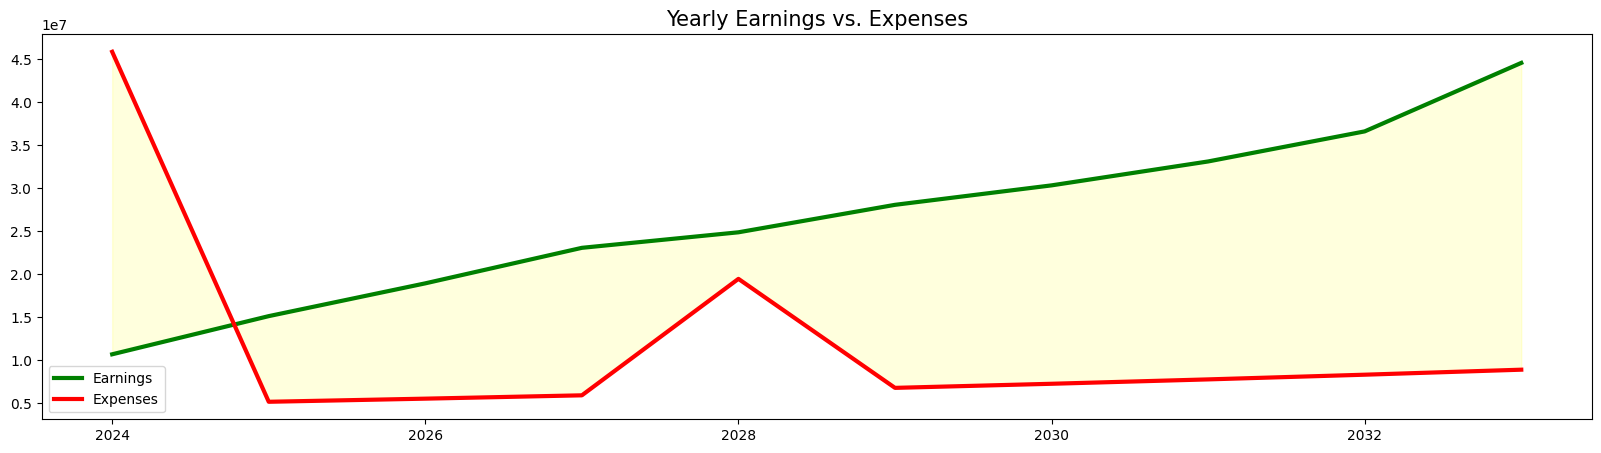

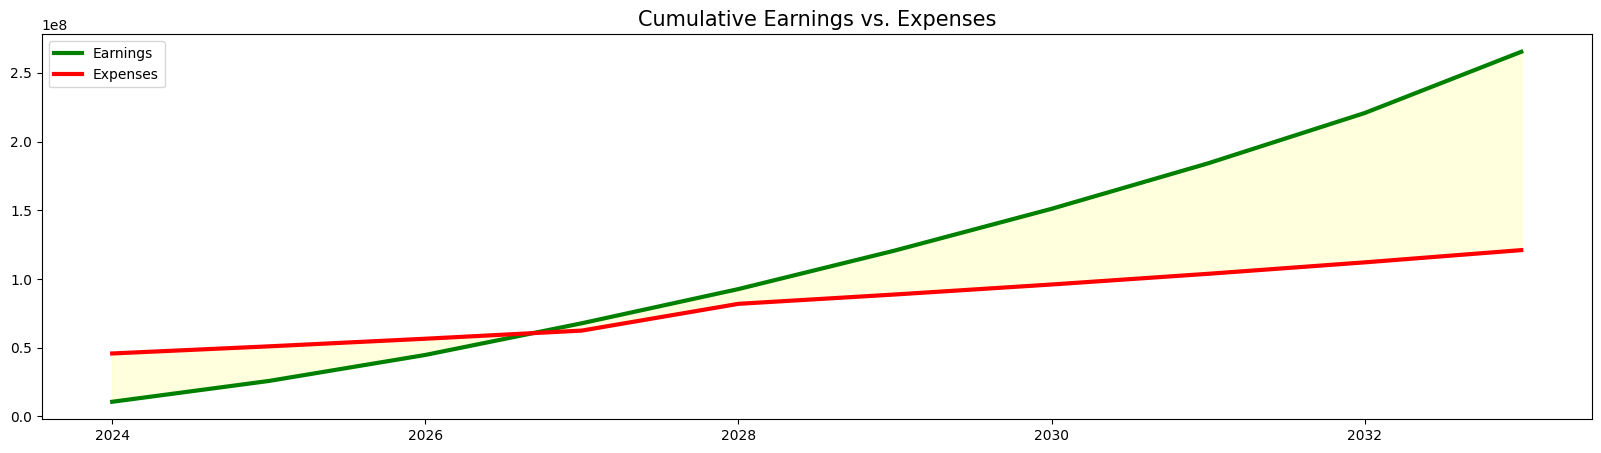

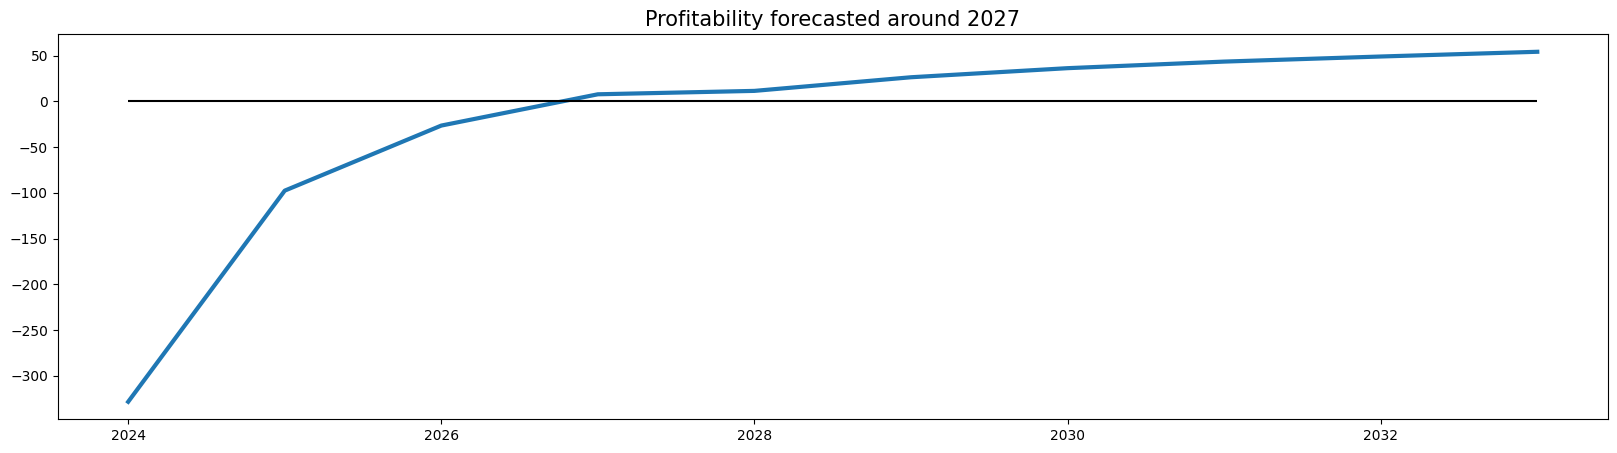

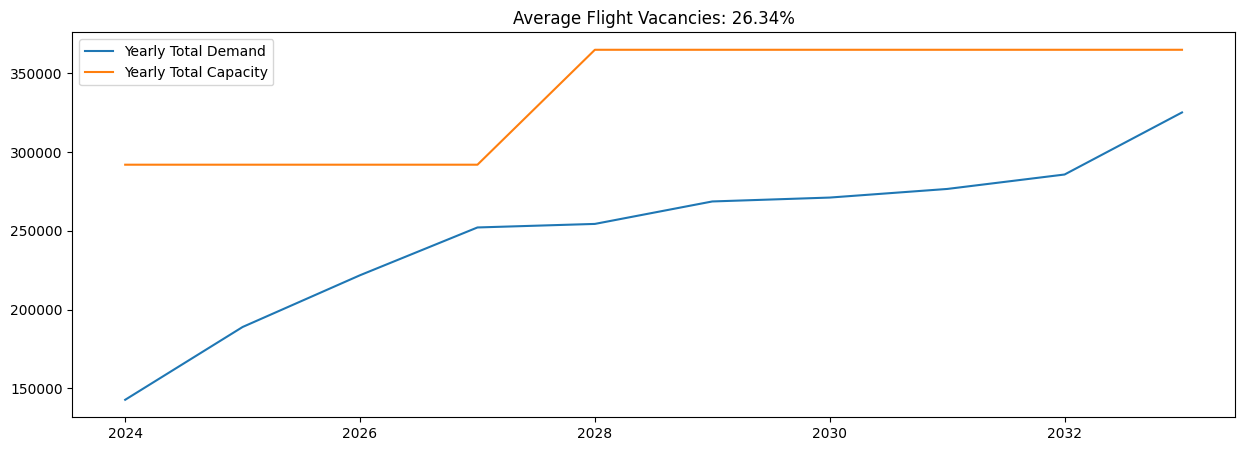

In [28]:
temp = [x for x in all_route_combo_info['Visakhapatnam_BOM'] if x[1] == True][0]
print(temp[0])
plot_cost_resource_analysis(temp[1], **temp[2])

In [15]:
# analysis_points = [*np.arange(0, FORECAST_YEAR - PRESENT_YEAR + 1, 3) + 3] + [FORECAST_YEAR - PRESENT_YEAR]
# print(analysis_points)

# NUM_COMBOS = 1
# num_planes_all_combos = [(0, 0)]
# addition_planes_all_combos = []

# feasible = True

# num_narrow_in_start = 0
# num_turbo_in_start = 0
# num_narrow_out_start = 0
# num_turbo_out_start = 0
# count = 0

# for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 2)):
    
#     if(year_idx in analysis_points):
        
#         a_in = 0
#         b_in = 0
#         h_in = 0
#         g_in = 365 * (CAPACITY_NARROW_BODY) / 2
#         f_in = 365 * (CAPACITY_TURBOPROP) / 2
#         c_in = -MARKET_SHARE_IN * DEMAND_IN_MAX

#         a_out = 0
#         b_out = 0
#         h_out = 0
#         g_out = 365 * (CAPACITY_NARROW_BODY) / 2
#         f_out = 365 * (CAPACITY_TURBOPROP) / 2
#         c_out = -MARKET_SHARE_OUT * DEMAND_OUT_MAX

#         def find_solution(n_narrow, n_turbo, a, b, h, g, f, c):
#             return ((a*(n_narrow ** 2)) + (b*(n_turbo ** 2)) + 2*h*n_narrow*n_turbo + 2*g*n_narrow + 2*f*n_turbo + c > 0)

#         solutions_in = []
#         for n_narrow in np.arange(num_narrow_in_start, FLEET_NARROWBODY + 1):
#             for n_turbo in np.arange(num_turbo_in_start, FLEET_TURBOPROP + 1):
#                 if(find_solution(n_narrow, n_turbo, a_in, b_in, h_in, g_in, f_in, c_in)):
#                     solutions_in.append((n_narrow, n_turbo))
        
#         solutions_out = []
#         for n_narrow in np.arange(num_narrow_out_start, FLEET_NARROWBODY + 1):
#             for n_turbo in np.arange(num_turbo_out_start, FLEET_TURBOPROP + 1):
#                 if(find_solution(n_narrow, n_turbo, a_out, b_out, h_out, g_out, f_out, c_out)):
#                     solutions_out.append((n_narrow, n_turbo))
        
#         if(len(solutions_in) == 0):
#             feasible = False
#             break
        
#         if(len(solutions_out) == 0):
#             feasible = False
#             break
        
#         solutions = list(set(solutions_in).intersection(set(solutions_out)))
#         sorted_combos = sorted(solutions, key = lambda x: CAPACITY_NARROW_BODY * x[0] + CAPACITY_TURBOPROP * x[1])
#         NUM_NARROW, NUM_TURBOPROP = sorted_combos[0]

#         assert(a_in * (NUM_NARROW ** 2) + b_in * (NUM_TURBOPROP ** 2) + 2 * h_in * NUM_NARROW * NUM_TURBOPROP + 2 * g_in * NUM_NARROW + 2 * f_in * NUM_TURBOPROP + c_in > 0)
#         assert(a_out * (NUM_NARROW ** 2) + b_out * (NUM_TURBOPROP ** 2) + 2 * h_out * NUM_NARROW * NUM_TURBOPROP + 2 * g_out * NUM_NARROW + 2 * f_out * NUM_TURBOPROP + c_out > 0)

#         addition_planes_all_combos.extend([(NUM_NARROW - num_planes_all_combos[-1][0], NUM_TURBOPROP - num_planes_all_combos[-1][1], count + ((FORECAST_YEAR - PRESENT_YEAR) - year_idx))] * count)
#         num_planes_all_combos.extend([(NUM_NARROW, NUM_TURBOPROP)] * count)
#         count = 0
#         DEMAND_IN_MAX = 0
#         DEMAND_OUT_MAX = 0
#         num_narrow_in_start = NUM_NARROW
#         num_turbo_in_start = NUM_TURBOPROP
#         num_narrow_out_start = NUM_NARROW
#         num_turbo_out_start = NUM_TURBOPROP
    
#     if(year <= FORECAST_YEAR):
#         year_forecasts = forecasts[forecasts['Year'] == year]    
#         in_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic']
#         out_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic']
#         if(in_demand > DEMAND_IN_MAX):
#             DEMAND_IN_MAX = in_demand
#         if(out_demand > DEMAND_OUT_MAX):
#             DEMAND_OUT_MAX = out_demand
#         count += 1

# if(feasible == False):
#     print("Current conditions are not feasible!")
# else:
#     num_planes = num_planes_all_combos
#     addition_planes = addition_planes_all_combos
#     num_planes = num_planes[1:]
#     addition_planes = list(set(addition_planes))
#     print(num_planes)
#     print(addition_planes)
#     print()

In [17]:
EARNINGS = []

def inflation(price):
    return price * (1 + INFLATION_RATE / 100)
def inflation_total(price, duration):
    return price * ((1 + INFLATION_RATE / 100) ** duration)

current_price_in = PRICE_IN
current_price_out = PRICE_OUT
for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)):
    num_narrow, num_turbo = num_planes[year_idx]
    year_forecasts = forecasts[forecasts['Year'] == year]
    in_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic']
    out_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic']
    EARNINGS.append(
        (
            (in_demand * MARKET_SHARE_IN * current_price_in) +
            (out_demand * MARKET_SHARE_OUT * current_price_out)
        )
    )
    current_price_in = inflation(current_price_in)
    current_price_out = inflation(current_price_out)

print(EARNINGS)

[9087195.98618114, 11148426.474237164, 14472900.481343795, 21134814.753730245, 26461688.822917957, 27043022.732792877, 32449907.948187843, 35540796.968590036, 77674617.30798683, 101794550.55264127]


In [18]:
fixed_expenses_factor = 0
operating_expenses_factor = 0
for idx in range(FORECAST_YEAR - PRESENT_YEAR):
    operating_expenses_factor += (((duration_in + duration_out) / 60) * num_planes[idx][0] * (CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP) * 365 + ((duration_in + duration_out) / 60) * num_planes[idx][1]) * inflation_total(1, idx)
for idx in range(len(addition_planes)):
    fixed_expenses_factor += (addition_planes[idx][0] * CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP + addition_planes[idx][1]) * inflation_total(1, FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2])
other_expenses_factor = 1
total_earnings = np.sum(EARNINGS)
print(fixed_expenses_factor, operating_expenses_factor, total_earnings)

17.24407239650547 106002.90295459857 356807922.02860916


In [19]:
FIXED_COSTS = (total_earnings * (1 - PROFIT_MARGIN / 100) / fixed_expenses_factor) / 3
OPERATING_COSTS = (total_earnings * (1 - PROFIT_MARGIN / 100) / operating_expenses_factor) / 3
OTHER_COSTS = (total_earnings * (1 - PROFIT_MARGIN / 100) / other_expenses_factor) / 3

def check_cost_equation(fixed, operating, other):
    profitability = (fixed * fixed_expenses_factor + operating * operating_expenses_factor + other_expenses_factor * other - total_earnings * (1 - PROFIT_MARGIN / 100))
    return profitability, (profitability <= 0)
print(check_cost_equation(FIXED_COSTS, OPERATING_COSTS, OTHER_COSTS))

print(FIXED_COSTS, OPERATING_COSTS, OTHER_COSTS)

(0.0, True)
3448604.577699375 561.0033814851141 59467987.00476819


In [40]:
# https://simpleflying.com/the-cost-of-flying/
# Minimum costs involved

print(check_cost_equation(FIXED_COSTS, OPERATING_COSTS, OTHER_COSTS))

(-4903198.019703895, True)


In [41]:
EXPENSES = [0] * (FORECAST_YEAR - PRESENT_YEAR)
EXPENSES[0] += OTHER_COSTS
current_operating_expense = OPERATING_COSTS
for idx in range(FORECAST_YEAR - PRESENT_YEAR):
    year_operating_expense = current_operating_expense * (((duration_in + duration_out) / 60) * num_planes[idx][0] * (CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP) * 365 + ((duration_in + duration_out) / 60) * num_planes[idx][1])
    EXPENSES[idx] += year_operating_expense
    current_operating_expense = inflation(current_operating_expense)
for idx in range(len(addition_planes)):
    fixed_costs = FIXED_COSTS * (addition_planes[idx][0] * CAPACITY_NARROW_BODY / CAPACITY_TURBOPROP + addition_planes[idx][1]) * inflation_total(1, FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2])
    EXPENSES[FORECAST_YEAR - PRESENT_YEAR - addition_planes[idx][2]] += fixed_costs
EXPENSES

[30047460.0,
 50771.50000000001,
 54325.505000000005,
 12308611.375546668,
 62254.071834933355,
 66611.85686337869,
 75179131.99778624,
 152597.4137097453,
 163279.2326694275,
 55415720.04119029]

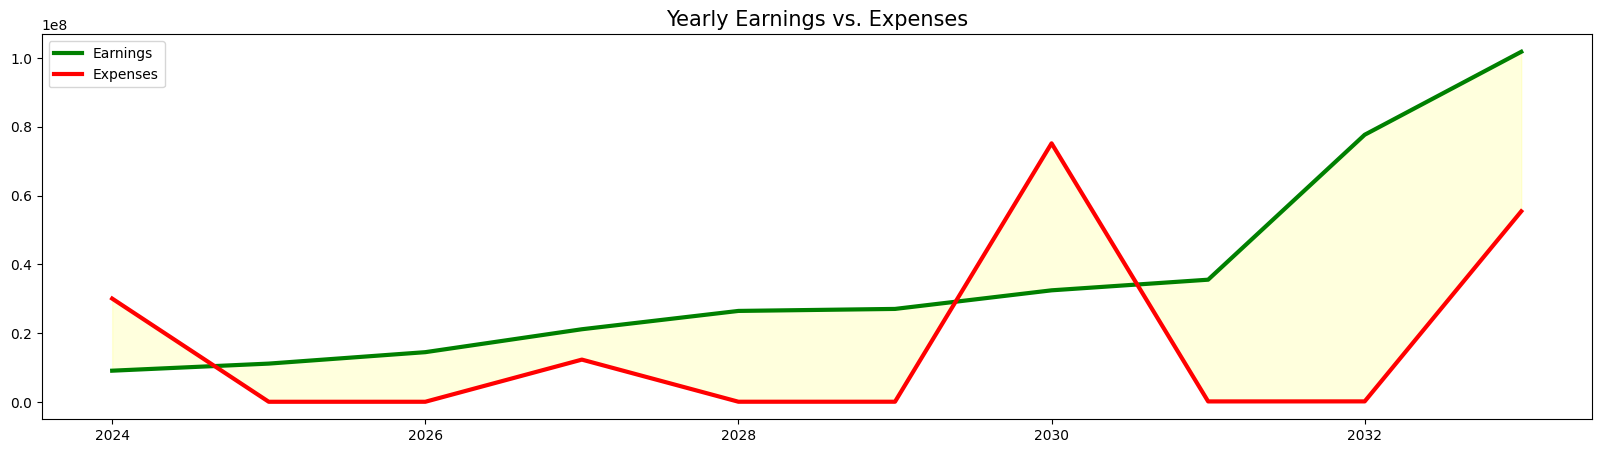

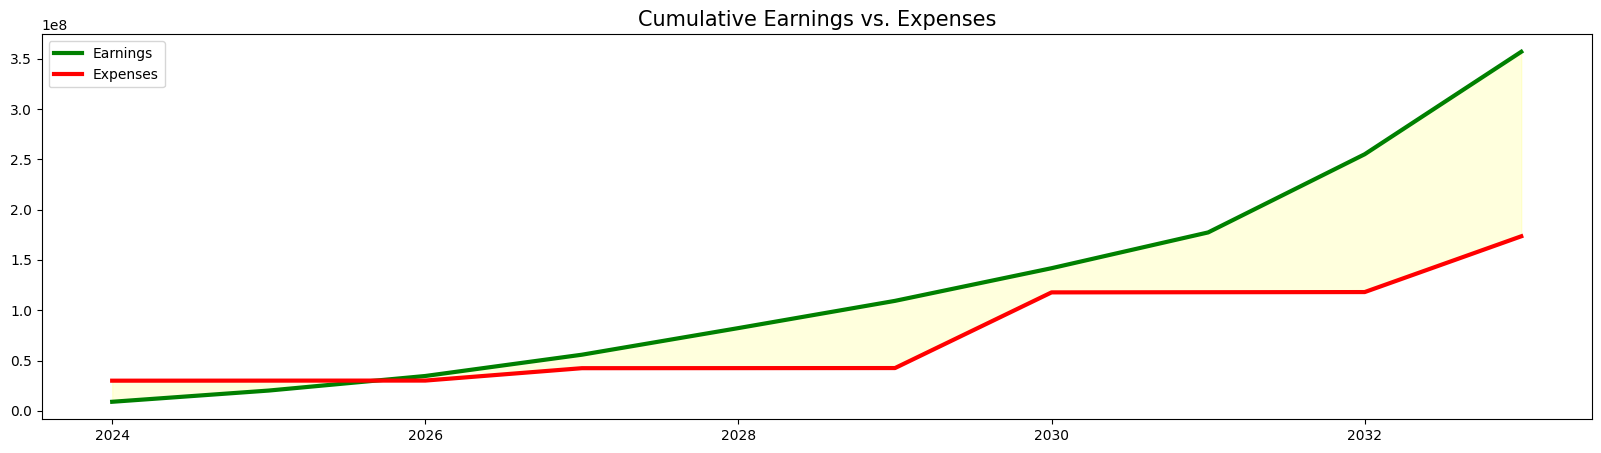

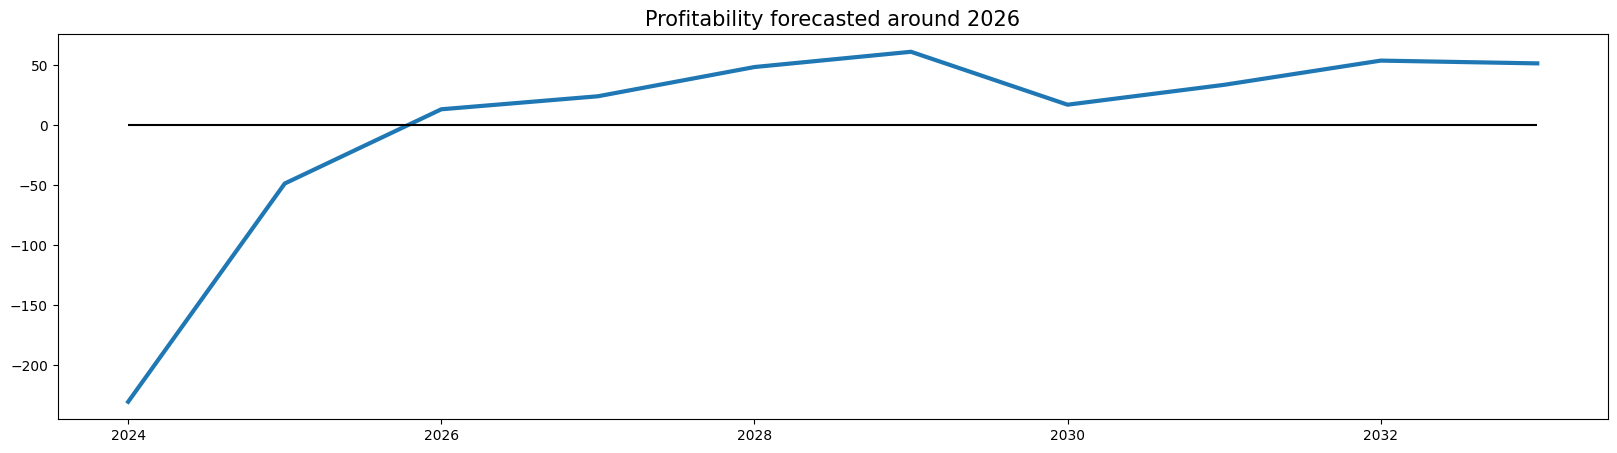

In [42]:
years = np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)
PROFIT_MARGIN_LIST = (np.cumsum(EARNINGS) - np.cumsum(EXPENSES)) / (np.cumsum(EARNINGS)) * 100
profitability_year = years[np.where((np.cumsum(EARNINGS) - np.cumsum(EXPENSES)) > 0)[0][0]]
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.lineplot(x = years, y = EARNINGS, label = "Earnings", ax = ax, color = 'green', linewidth = 3)
sns.lineplot(x = years, y = EXPENSES, label = "Expenses", ax = ax, color = 'red', linewidth = 3)
ax.fill_between(years, EARNINGS, EXPENSES, color = '#ffff0022')
ax.legend(loc = 'best', fontsize = 10)
ax.set_title(f"Yearly Earnings vs. Expenses", fontsize = 15)
plt.show()
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.lineplot(x = years, y = np.cumsum(EARNINGS), label = "Earnings", ax = ax, color = 'green', linewidth = 3)
sns.lineplot(x = years, y = np.cumsum(EXPENSES), label = "Expenses", ax = ax, color = 'red', linewidth = 3)
ax.fill_between(years, np.cumsum(EARNINGS), np.cumsum(EXPENSES), color = '#ffff0022')
ax.legend(loc = 'best', fontsize = 10)
ax.set_title(f"Cumulative Earnings vs. Expenses", fontsize = 15)
plt.show()
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.lineplot(x = years, y =PROFIT_MARGIN_LIST, linewidth = 3)
ax.hlines(0, xmin = years[0], xmax = years[-1], color = 'black')
ax.set_title(f"Profitability forecasted around {profitability_year}", fontsize = 15)
plt.show()

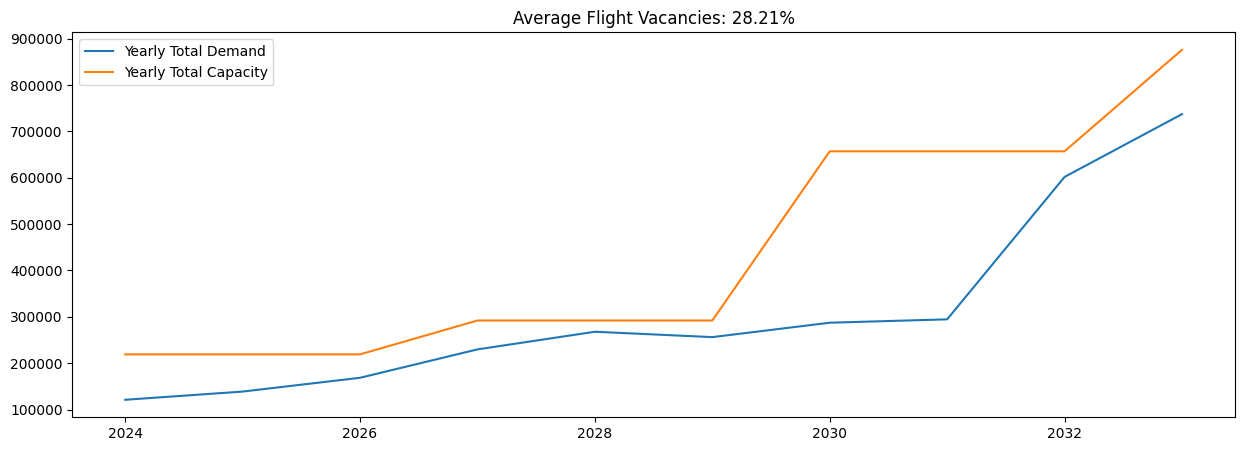

In [43]:
total_demands = []
total_capacities = []
total_flight_vacancies = []
for year_idx, year in enumerate(np.arange(PRESENT_YEAR + 1, FORECAST_YEAR + 1)):
    year_forecasts = forecasts[forecasts['Year'] == year]
    total_demand = year_forecasts.iloc[0]['AdjustedForecastedDemand_InTraffic'] * MARKET_SHARE_IN + year_forecasts.iloc[0]['AdjustedForecastedDemand_OutTraffic'] * MARKET_SHARE_OUT
    total_capacity = (num_planes[year_idx][0] * CAPACITY_NARROW_BODY + num_planes[year_idx][1] * CAPACITY_TURBOPROP) * 2 * 365
    total_demands.append(total_demand)
    total_capacities.append(total_capacity)
    total_flight_vacancies.append(1 - (total_demand / total_capacity))

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.lineplot(x = years, y = total_demands, label = 'Yearly Total Demand', ax = ax)
sns.lineplot(x = years, y = total_capacities, label = 'Yearly Total Capacity', ax = ax)
ax.legend(loc = 'best')
ax.set_title(f"Average Flight Vacancies: {np.mean(total_flight_vacancies) * 100:.2f}%")
plt.show()